In [ ]:
# Python Script
# Calibration of the diffraction projection
# from a diffraction pattern of a known crystal
#
# by J. Barthel / Forschungszentrum Jülich GmbH, Jülich, Germany
# email: ju.barthel@fz-juelich.de
#
# part of the emilys project: https://github.com/ju-bar/emilys
# published under the GNU GPL 3.0 License
#
# - record with as parallel illumination as possible
# - avoid recording noisy data (make long exposures)
# - avoid over saturation of the detector
# - avoid strong diffraction defocus or astigmatism

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arrow
from scipy.optimize import curve_fit
import emilys.image.arrayplot as aplt
from emilys.numerics.mc import mc_image_pos_maximize
from emilys.image.imagedata import image_pos_sum
import emilys.numerics.cluster as clus

In [2]:
sworkdir = '../data/' # ! Set working directory !
ldat0 = np.fromfile(sworkdir + 'dif_cal_avg.dat', dtype='float64') # load the image data

<IPython.core.display.Javascript object>


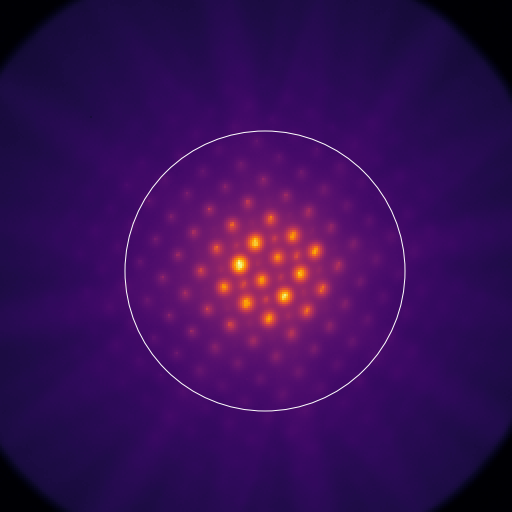

In [16]:
ndim = np.array([256,256]) # ! Set image dimension !
pcenter = np.array([132.,120.]) # ! Set center of peak search area !
prange = 70. # ! Set range of peak search area !
limg0 = ldat0.reshape(ndim) # get the image in shape
%matplotlib notebook
plot0 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image and enhance low at low intensities
prangecircle = Circle(pcenter, prange, color='w', fill=False)
ax = plt.gca()
ax.add_patch(prangecircle)

In [4]:
# try locating local minima using a Monte-Carlo
# - determine the intensity variations for pixels close to the range circle defined above
sr1 = 0.
sr2 = 0.
srn = 0
si = 0.
for j in range(0,ndim[0]):
    for i in range(0,ndim[1]):
        if np.abs(np.sqrt((i-pcenter[0])**2 + (j-pcenter[1])**2) - prange) < 1.:
            si = limg0[j,i]
            sr1 += si
            sr2 += si**2
            srn += 1
rmean = sr1 / srn
rsdev = np.sqrt(sr2 / srn - rmean*rmean)
print('- intensity on range limit (mean, sdev):',[rmean,rsdev])
# initialize a list of points (one for each second pixel in the range)
lrpt = np.array([])
nrpt = 0
for j in range(0,ndim[0],2):
    for i in range(0,ndim[1],2):
        if np.sqrt((i - pcenter[0])**2 + (j - pcenter[1])**2) < prange:
            if nrpt == 0:
                lrpt = np.array([[1.*i,1.*j]])
            else:
                lrpt = np.concatenate((lrpt,np.array([[1.*i,1.*j]])))
            nrpt += 1
print('- test points for peak finding:', lrpt.shape[0])

- intensity on range limit (mean, sdev): [1.2812710840373993, 0.20246023620516143]
- test points for peak finding: 3841


In [5]:
# repeat until iterations < itmax
# decrease step and temperture to improve
itmax = 200
s0 = image_pos_sum(limg0, lrpt)
nit = mc_image_pos_maximize(limg0, lrpt, 1., rsdev/100, itmax)
s1 = image_pos_sum(limg0, lrpt)
print('- initial:', s0, ', final:', s1, ', iterations:', nit)

- initial: 23052.378052632757 , final: 102210.43809412359 , iterations: 200


<IPython.core.display.Javascript object>


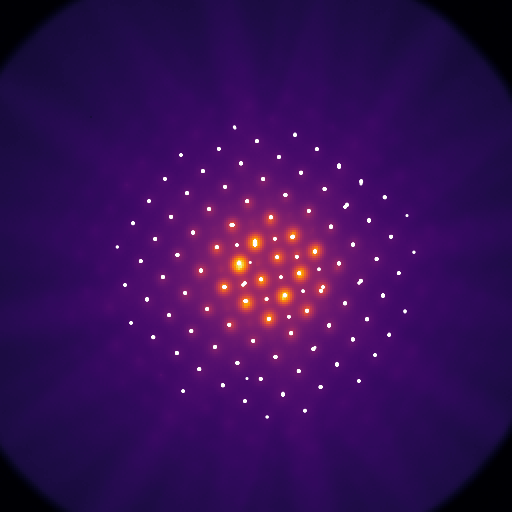

In [6]:
plot1 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image
# show points
ax = plt.gca()
for l in range(0,lrpt.shape[0]):
    prangecircle = Circle(lrpt[l], 0.5, color='w', fill=True)
    ax.add_patch(prangecircle)

In [11]:
ierr = 0
lcl = clus.cluster_l2(lrpt, 4., ierr)
if ierr>0:
    print('Error: cluster recognition failed. Code', ierr)
else:
    print('- number of clusters:', len(lcl.lcluster)) 

-  3841 of 3841  items assigned to  106  clusters
- number of clusters: 106


- reducing to clusters with more than  7  votes ...


<IPython.core.display.Javascript object>


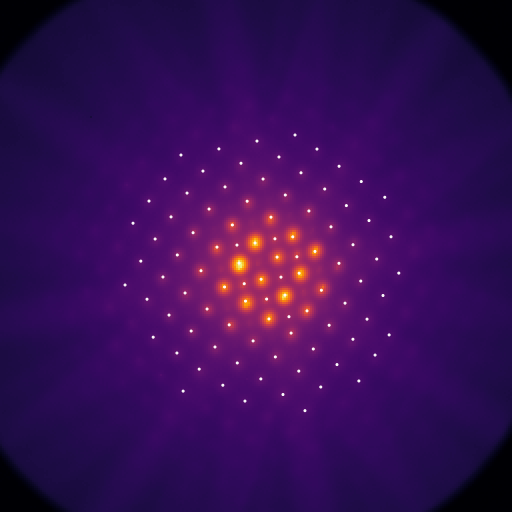

- 95  peaks suggested.
- smallest distance [pix]: 8.235112392239593


In [133]:
# tune number of cluster population so that small clusters (stray detections disappear)
nclpop = int(lrpt.shape[0] / len(lcl.lcluster) / 5)
print('- reducing to clusters with more than ', nclpop,' votes ...')
lpk0 = []
plot2 = aplt.arrayplot2d(limg0**0.3, 2, 'inferno') # plot image
# show points
ax = plt.gca()
for l in range(0, len(lcl.lcluster)):
    if len(lcl.lcluster[l].population) > nclpop:
        lpk0.append(lcl.lcluster[l].mean)
        prangecircle = Circle(lpk0[len(lpk0)-1], 0.5, color='w', fill=True)
        ax.add_patch(prangecircle)
print('-',len(lpk0),' peaks suggested.')
# calculate smallest distance found ...
dmin = ndim[0] + ndim[1]
for l in range(0, len(lpk0)-1):
    pl = np.array(lpk0[l])
    for k in range(l+1, len(lpk0)):
        pk = np.array(lpk0[k])
        vd = pk - pl
        dmin = min(dmin, np.sqrt(np.dot(vd,vd)))
print('- smallest distance [pix]:', dmin)

In [134]:
# improve peak positions by fitting a Gaussian peak function to the local data
# - initialize a list of peak data
pkrad = 0.5*(dmin-1.) # ! Set pixel radius to include data (keep it small) !
npk = len(lpk0) # get number of peaks
lpk0dat = [] # initialize list of data for fitting
# - collect data
for l in range(0,npk): # loop through pre-estimated peak positions
    lpkdat = [] # initialize list of data
    i0, j0 = np.floor(lpk0[l] - pkrad).astype(int)
    i1, j1 = np.ceil(lpk0[l] + pkrad).astype(int)
    for j in range(j0, j1+1):
        for i in range(i0, i1+1):
            lpkdat.append([i,j,limg0[j,i]])
    lpk0dat.append(lpkdat)

In [135]:
def pkfun(x_tuple, xc0, xc1, w, a0, a1):
    '''2D Gaussian peak function: (xdata,*a) -> y, xdata = [[vx0,vy0],[vx1,vy1], ... ,[vxN,vyN]]'''
    (x0, x1) = x_tuple
    dx0 = x0 - xc0
    dx1 = x1 - xc1
    d2 = dx0*dx0 + dx1*dx1
    w2 = w**2
    vexp = 0. # init for abnormal width
    if (w2 > 0.): # normal width
        vexp = np.exp( -0.5 * d2 / w2 )
    return a0 + a1 * vexp    

In [156]:
lpk1 = []
for ipk in range(0,npk):
    pkx = lpk0[ipk]
    pkdat = np.array(lpk0dat[ipk])
    x = pkdat.T[0]
    y = pkdat.T[1]
    z = pkdat.T[2]
    prm0 = [pkx[0], pkx[1], 0.5*pkrad, np.min(z), np.max(z) - np.min(z)]
    solprm, solcov = curve_fit(pkfun, np.vstack((x,y)), z, prm0)
    solerr = np.sqrt(np.diag(solcov))
    vcshift = pkx - np.array([solprm[0],solprm[1]])
    if np.sqrt(np.dot(vcshift,vcshift)) < 0.5 * pkrad and solprm[2] < pkrad and 4 * rsdev < solprm[4]:
        lpk1.append([solprm,solerr])
npkf = len(lpk1)
lpkf = np.array(lpk1)
print('-', npkf, ' peaks accepted.')

- 79  peaks accepted.


<IPython.core.display.Javascript object>


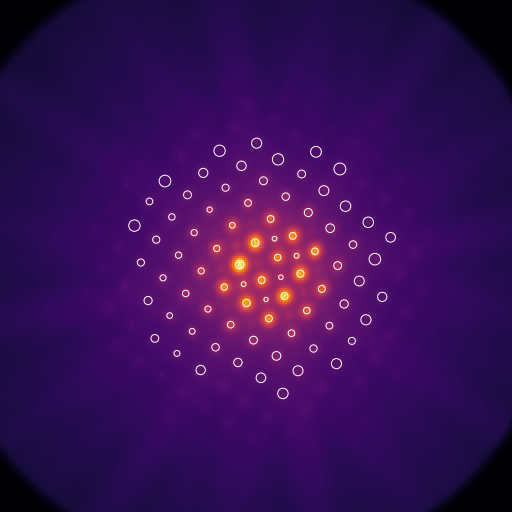

In [157]:
plot3 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image
# show points
ax = plt.gca()
for l in range(0,len(lpk1)):
    pos = np.array([lpk1[l][0][0],lpk1[l][0][1]])
    prangecircle = Circle(pos, lpk1[l][0][2], color='w', fill=False)
    ax.add_patch(prangecircle)

In [176]:
# locate the peak closest to the image center
posc = 0.5 * ndim
dmin = np.sqrt(np.dot(lpkf[0,0,0:2] - posc,lpkf[0,0,0:2] - posc))
imin = 0
for l in range(1, npkf):
    vd = lpkf[l,0,0:2] - posc
    dist = np.sqrt(np.dot(vd,vd))
    if dist < dmin:
        imin = l
        dmin = dist
icenter = imin
pcenter = lpkf[icenter,0,0:2]
print('- choosing center peak (ID, pos):', [icenter, [pcenter[0],pcenter[1]]])
# locate the next peak pointing along the horizontal axis ...
dmin = 1. * ndim[0]
imin = -1
for l in range(0, npkf):
    vd = lpkf[l,0,0:2] - pcenter
    dist = np.sqrt(np.dot(vd,vd))
    dpx = np.dot(vd,np.array([1.,0]))
    if dist < dmin and l != icenter and dpx > pkrad:
        imin = l
        dmin = dist
iplane0 = imin
pplane0 = lpkf[iplane0,0,0:2]
vplane0 = pplane0 - pcenter
print('- x-axis (ID, pos):', [iplane0, dmin, [vplane0[0],vplane0[1]]])
# ... and one in the perpendicular direction
vpy = np.dot(np.array([[0.,-1],[1.,0.]]),vplane0 / np.sqrt(np.dot(vplane0,vplane0)))
dmin = 1. * ndim[0]
imin = -1
for l in range(0, npkf):
    vd = lpkf[l,0,0:2] - pcenter
    dist = np.sqrt(np.dot(vd,vd))
    dpy = np.dot(vd,vpy)
    if dist < dmin and l != icenter and dpy > 0.9*dist:
        imin = l
        dmin = dist
iplane1 = imin
pplane1 = lpkf[iplane1,0,0:2]
vplane1 = pplane1 - pcenter
print('- x-axis (ID, pos):', [iplane1, dmin, [vplane1[0],vplane1[1]]])

- choosing center peak (ID, pos): [48, [127.10329976853025, 134.1152345256039]]
- x-axis (ID, pos): [51, 9.88970151494561, [9.674285541188354, 2.0528992479592034]]
- x-axis (ID, pos): [64, 20.26073641295019, [-3.571395827827729, 19.943484445703575]]


<IPython.core.display.Javascript object>


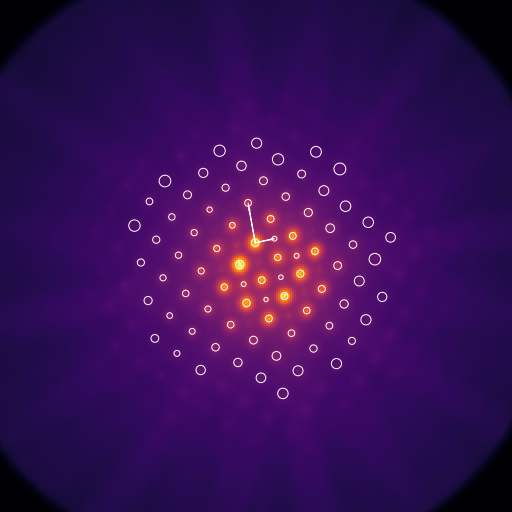

In [177]:
plot4 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image
# show points
ax = plt.gca()
for l in range(0, npkf):
    pos = lpkf[l,0,0:2]
    prangecircle = Circle(pos, lpkf[l,0,2], color='w', fill=False)
    ax.add_patch(prangecircle)
parr0 = Arrow(pcenter[0], pcenter[1], vplane0[0], vplane0[1], color='w')
ax.add_patch(parr0)
parr1 = Arrow(pcenter[0], pcenter[1], vplane1[0], vplane1[1], color='w')
ax.add_patch(parr1)

In [217]:
# Look at the plot and assign [hk] indices to the two arrows !
# This requires, that the two arrows are not parallel or anti-parallel.
hk0 = [1,0] # ! Set the [hk] for the arrow pointing right !
hk1 = [0,2] # ! Set the [hk] for the arrow pointing up !
# Set parameters determining the k-space scale, i.e. the projected Bragg spot vectors.
q10 = [2.563, 0.] # ! Set the reciprocal space vector corresponding to [10] in physical units !
q01 = [0., 2.563] # ! Set the reciprocal space vector corresponding to [01] in physical units !
# Set the center of the projection.
# This is a reference point, required for non-linear distortions.
p00 = [127.64, 125.63] # ! Set the position of the zero beam / probe-forming aperture center !
#
# translate the given pixel basis vectors to grid basis vectors
mhk = np.array([hk0,hk1])
mhki = np.linalg.inv(mhk)
pbase = np.array([vplane0,vplane1])
bhk = np.dot(mhki,pbase).T
bhki = np.linalg.inv(bhk)
#
# Predict peak positions from the parameters and keep those close to the measured peaks
lpkfhk = np.zeros((npkf,2), dtype=int)
lpkfpred = np.zeros((npkf,2), dtype=float)
for l in range(0, npkf): # loop over all peaks
    vpos = lpkf[l,0,0:2] - pcenter
    lpkfhk[l] = np.round(np.dot(bhki,vpos)).astype(int)
    lpkfpred[l] = np.dot(bhk,lpkfhk[l]) + pcenter

<IPython.core.display.Javascript object>


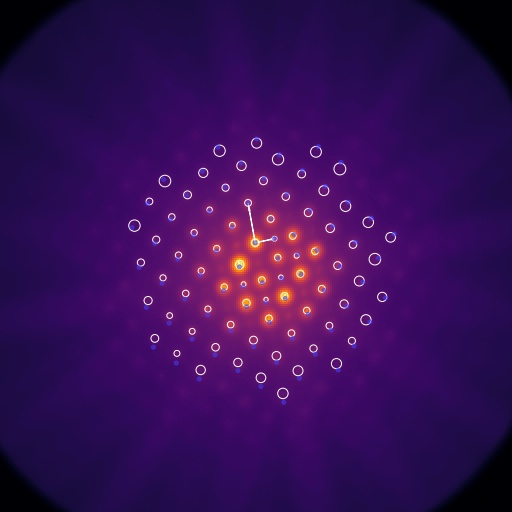

In [226]:
# Plot measured (white) vs. predicted (blue) peak positions.
# The prediction may be bad but should reflect the measured pattern.
# In case of strong variations, strong distortions are present.
# - Strong distortions would require an iterative fitting below.
plot5 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image
# show points
ax = plt.gca()
parr0 = Arrow(pcenter[0], pcenter[1], vplane0[0], vplane0[1], color='w')
ax.add_patch(parr0)
parr1 = Arrow(pcenter[0], pcenter[1], vplane1[0], vplane1[1], color='w')
ax.add_patch(parr1)
for l in range(0, npkf):
    pos = lpkf[l,0,0:2]
    pcircm = Circle(pos, lpkf[l,0,2], color='w', fill=False)
    ax.add_patch(pcircm)
    pos = lpkfpred[l]
    pcircp = Circle(pos, 1.0, color='#4040ff80', fill=True)
    ax.add_patch(pcircp)